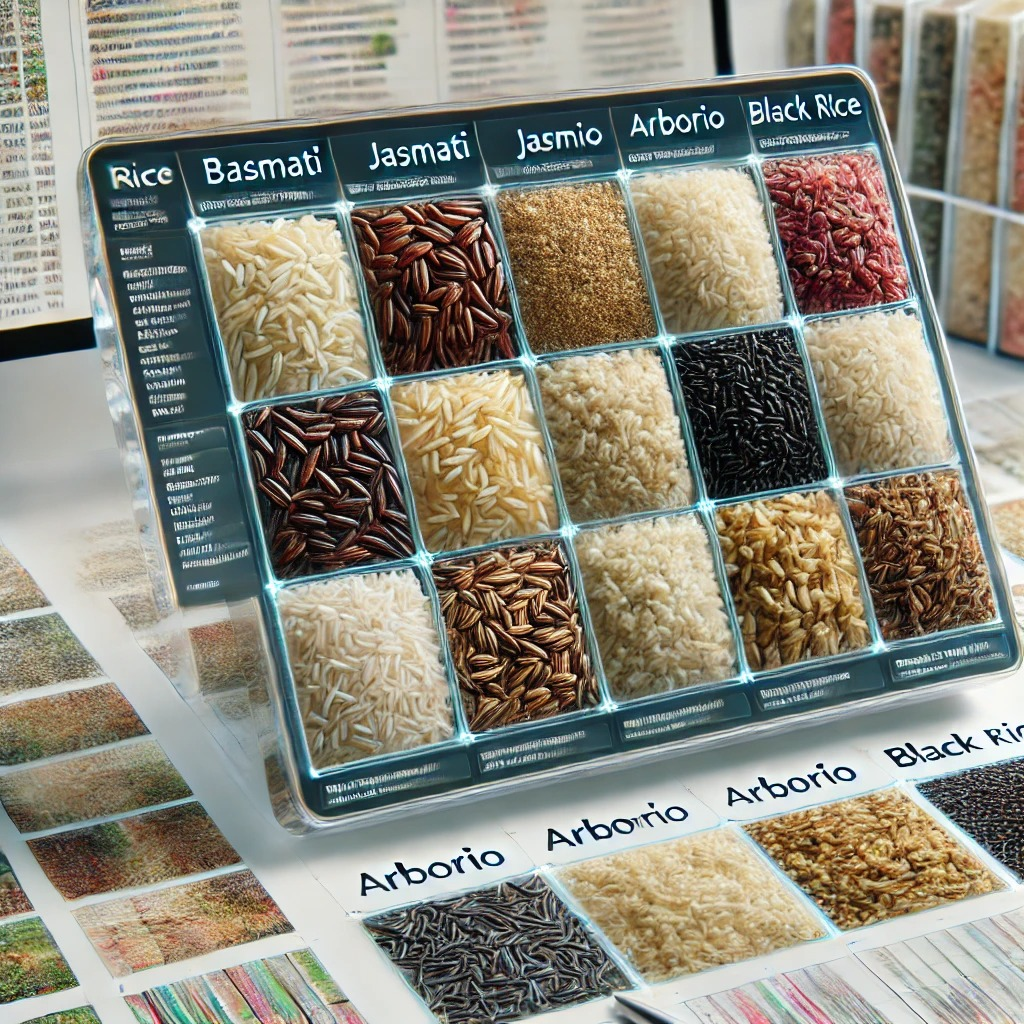

# 1. Introduction

Rice is one of the most widely produced grains globally, with numerous genetic varieties. These varieties differ based on characteristics such as texture, shape, and color. By analyzing these distinguishing features, it is possible to classify rice varieties and assess seed quality.

In this study, five rice varieties commonly grown in Turkey—Arborio, Basmati, Ipsala, Jasmine, and Karacadag—were examined. The dataset includes 75,000 grain images, with 15,000 images from each variety. 

To classify the data, Artificial Neural Network (ANN) and Deep Neural Network (DNN) algorithms were applied to the feature dataset, while the Convolutional Neural Network (CNN) algorithm was used for the image dataset. 

# 2. Project Goal

The goal is to develop a CNN / PyTorch model that can accurately identify different rice varieties from their images.


In [1]:
!pip install torch

In [2]:
!pip install torchvision

In [4]:
!pip install torch-summary

In [10]:
!pip install torchview

# 3. Libraries

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from torchsummary import summary
import torch.optim as optim
import warnings
warnings.simplefilter(action="ignore")
import random
import torch
from torchview import draw_graph

# 4. Reading dataset

In [12]:
data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

In [13]:
# List the folder's name of Dataset
folder_names = os.listdir(data_dir)
folder_names

['Karacadag',
 'Basmati',
 'Jasmine',
 'Rice_Citation_Request.txt',
 'Arborio',
 'Ipsala']

# 5. Dataset Preparation

## 5.1. Image resize & Create one folder for all images

In [14]:
transform = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])

In [15]:
dataset = datasets.ImageFolder(data_dir, transform=transform)

## 5.2. Count the data in each subfolder 

In [ ]:
# Load the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Count the number of images in each class
data_counts = {class_name: len(os.listdir(os.path.join(data_dir, class_name))) for class_name in dataset.classes}

for folder, count in data_counts.items():
    print(f"Folder: {folder}, Count: {count}")

## 5.3. Train/Validation/Test split

In [16]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

print("Train set samples: ",train_size)
print("Validation set samples: ",val_size)
print("Test set samples: ",test_size)

Train set samples:  52500
Validation set samples:  11250
Test set samples:  11250


In [17]:
# Split the dataset

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

## 5.4. Create data loaders

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 6. Visualization

## 6.1. Plot sample rice images

In [ ]:
# dataset = datasets.ImageFolder(data_dir, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=25, shuffle=True)  # Set batch_size=25 to fit grid

# Get Class Names
class_names = dataset.classes  

# Get a batch of images and labels
images, labels = next(iter(dataloader))

# Plot the Images
plt.figure(figsize=(8, 8))
for i in range(len(images)): 
    plt.subplot(5, 5, i + 1)  
    plt.imshow(images[i].permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    plt.title(class_names[labels[i].item()])  # Convert tensor label to integer index
    plt.axis("off")

plt.tight_layout()
plt.show()

## 6.2. Pie plot

In [ ]:
type_count = {}

for folders in folder_names:
    class_path = os.path.join(data_dir, folders)

    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        type_count[folders] = num_images

print(type_count)

In [ ]:
count = list(type_count.values())
label = list(type_count.keys())

fig = go.Figure(data=[go.Pie(labels=label,
                             values=count,
                             hole=0.5,
                             marker_colors=px.colors.sequential.Reds,
                             textinfo='label+percent',
                             insidetextorientation='radial')])

fig.update_layout(title='Rice Classes Distribution')
fig.show()

## 6.3. Bar plot

In [ ]:
# Get only folder names (excluding files)
folder_names = []
for item in os.listdir(data_dir):
    item_path = os.path.join(data_dir, item)
    if os.path.isdir(item_path):
        folder_names.append(item)

# Create a list of labels for all images
labels = []
for folder in folder_names:
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):  # Ensure it's a folder
        num_images = len(os.listdir(folder_path))  # Count images in the folder
        labels.extend([folder] * num_images)  # Add folder name as label for each image

palette = sns.color_palette("Reds", len(folder_names))

# Create the countplot
sns.countplot(x=labels, order=folder_names, palette=palette)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Image Classes')
plt.xticks(rotation=45)
plt.show()

# 7. Model 1: One Conv layer and two fully connected layers

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5),  
            nn.BatchNorm2d(num_features=12),
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=2),  
            
            
        )

        self.fc_model = nn.Sequential(
            nn.Linear(in_features=20 * 29 * 29, out_features=320),  
            nn.ReLU(), 
            nn.Linear(in_features=320, out_features=5)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)  # Flatten before feeding into fully connected layers
        x = self.fc_model(x)
        return x


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU (if available)
model = CNN().to(device)

In [29]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5),
            nn.BatchNorm2d(num_features=12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Correct in_features for Linear layer
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=12 * 62 * 62, out_features=320),  # Fixed size
            nn.ReLU(),
            nn.Linear(in_features=320, out_features=5)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_model(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

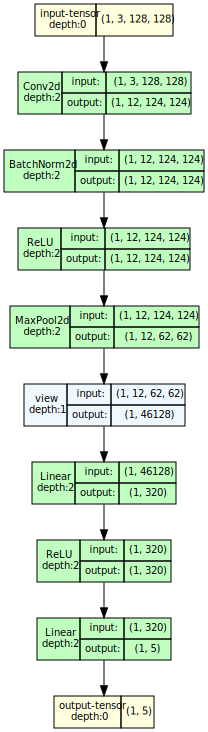

In [30]:
# Generate visualization
graph = draw_graph(model, input_size=(1, 3, 128, 128), device='cpu')
graph.visual_graph

## 7.1. Model Summary

In [31]:
summary(model, (3, 128, 128), device=str(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 12, 62, 62]          --
|    └─Conv2d: 2-1                       [-1, 12, 124, 124]        912
|    └─BatchNorm2d: 2-2                  [-1, 12, 124, 124]        24
|    └─ReLU: 2-3                         [-1, 12, 124, 124]        --
|    └─MaxPool2d: 2-4                    [-1, 12, 62, 62]          --
├─Sequential: 1-2                        [-1, 5]                   --
|    └─Linear: 2-5                       [-1, 320]                 14,761,280
|    └─ReLU: 2-6                         [-1, 320]                 --
|    └─Linear: 2-7                       [-1, 5]                   1,605
Total params: 14,763,821
Trainable params: 14,763,821
Non-trainable params: 0
Total mult-adds (M): 43.36
Input size (MB): 0.19
Forward/backward pass size (MB): 2.82
Params size (MB): 56.32
Estimated Total Size (MB): 59.32


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 12, 62, 62]          --
|    └─Conv2d: 2-1                       [-1, 12, 124, 124]        912
|    └─BatchNorm2d: 2-2                  [-1, 12, 124, 124]        24
|    └─ReLU: 2-3                         [-1, 12, 124, 124]        --
|    └─MaxPool2d: 2-4                    [-1, 12, 62, 62]          --
├─Sequential: 1-2                        [-1, 5]                   --
|    └─Linear: 2-5                       [-1, 320]                 14,761,280
|    └─ReLU: 2-6                         [-1, 320]                 --
|    └─Linear: 2-7                       [-1, 5]                   1,605
Total params: 14,763,821
Trainable params: 14,763,821
Non-trainable params: 0
Total mult-adds (M): 43.36
Input size (MB): 0.19
Forward/backward pass size (MB): 2.82
Params size (MB): 56.32
Estimated Total Size (MB): 59.32

## 7.2. Training Model

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [34]:
num_epochs = 5
train_losses, val_losses = [], []          # To track loss
train_accuracies, val_accuracies = [], []  # To track accuracy

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available
        
        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss tracking
        total_train_loss += loss.item()

        # Accuracy tracking
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_val += (preds == labels).sum().item()
        total_val += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")
    print(f"            Train Acc = {train_accuracies[-1]:.4f}, Val Acc = {val_accuracies[-1]:.4f}")

Epoch [1/5]
Epoch 1: Train Loss = 0.1456, Val Loss = 0.0305
            Train Acc = 0.9607, Val Acc = 0.9903
Epoch [2/5]
Epoch 2: Train Loss = 0.0529, Val Loss = 0.1331
            Train Acc = 0.9824, Val Acc = 0.9618
Epoch [3/5]
Epoch 3: Train Loss = 0.0490, Val Loss = 0.1359
            Train Acc = 0.9842, Val Acc = 0.9525
Epoch [4/5]
Epoch 4: Train Loss = 0.0368, Val Loss = 0.0371
            Train Acc = 0.9886, Val Acc = 0.9896
Epoch [5/5]
Epoch 5: Train Loss = 0.0315, Val Loss = 0.0376
            Train Acc = 0.9902, Val Acc = 0.9887


## 7.3. Model History

In [35]:
history = {
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies,
}

result_model1 = pd.DataFrame(history)
result_model1

,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
0,0.145650,0.030458,0.960743,0.990311
1,0.052904,0.133065,0.982438,0.961778
2,0.049020,0.135915,0.984229,0.952533
3,0.036779,0.037107,0.988552,0.989600
4,0.031522,0.037607,0.990190,0.988711


## 7.4. Plot train (Acc/ Loss) vs Validation (Acc/ Loss)

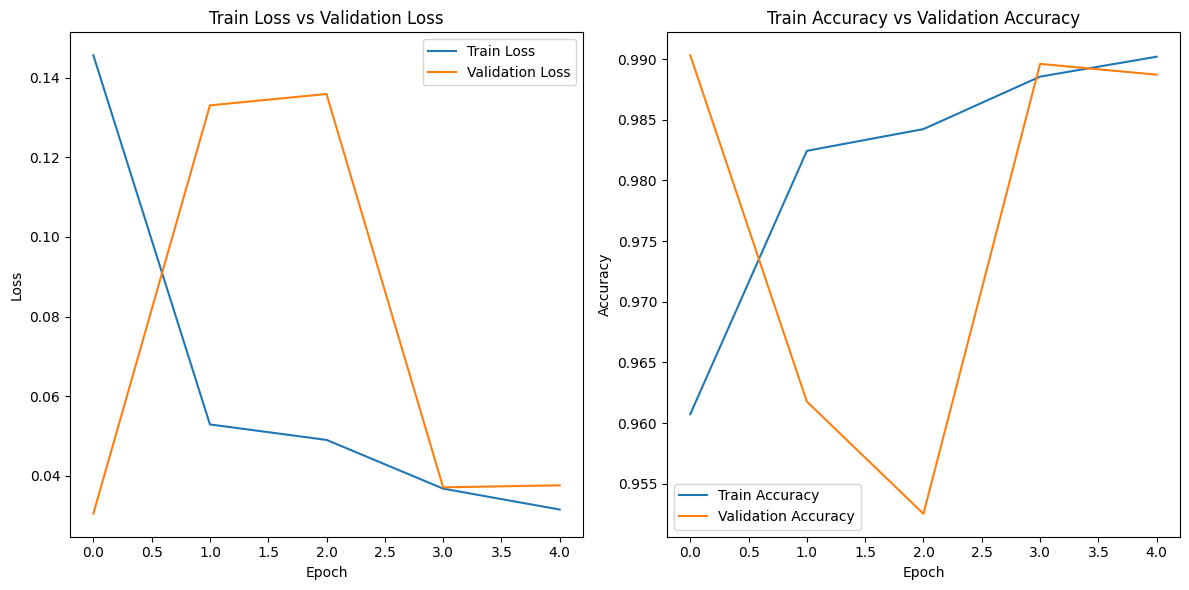

In [36]:
# Plot train loss vs validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(result_model1['Train Loss'], label='Train Loss')
plt.plot(result_model1['Validation Loss'], label='Validation Loss')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot train accuracy vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(result_model1['Train Accuracy'], label='Train Accuracy')
plt.plot(result_model1['Validation Accuracy'], label='Validation Accuracy')
plt.title('Train Accuracy vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 7.5. Test the model on the test set

In [37]:
# Set model to evaluation mode
model.eval()

# Initialize counters
correct = 0
total = 0
test_loss = []
all_preds = []
all_labels = []
all_images = []


with torch.no_grad():    # Disable gradient computation for efficiency
    for images, labels in test_loader:
        # Move data to the same device as the model
        images, labels = images.to(device), labels.to(device) 

        # output = prediction
        outputs  = model(images)
        loss = criterion(outputs, labels)
        test_loss.append(loss.item())
        
        # Get predicted class indices
        # preds = torch.argmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)  # Get predicted class indices
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

         # Store predictions and true labels for confusion matrix
        all_preds.extend(preds.cpu().numpy())  # Convert to list
        all_labels.extend(labels.cpu().numpy())  # Convert to list

# Compute average test loss
avg_test_loss = np.mean(test_loss)
print(f'Test Average loss: {avg_test_loss:.4f}')

# Compute and print test accuracy
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f} %')   

Test Average loss: 0.0409
Test Accuracy: 98.74 %


## 7.6. Actual vs Predicted Image

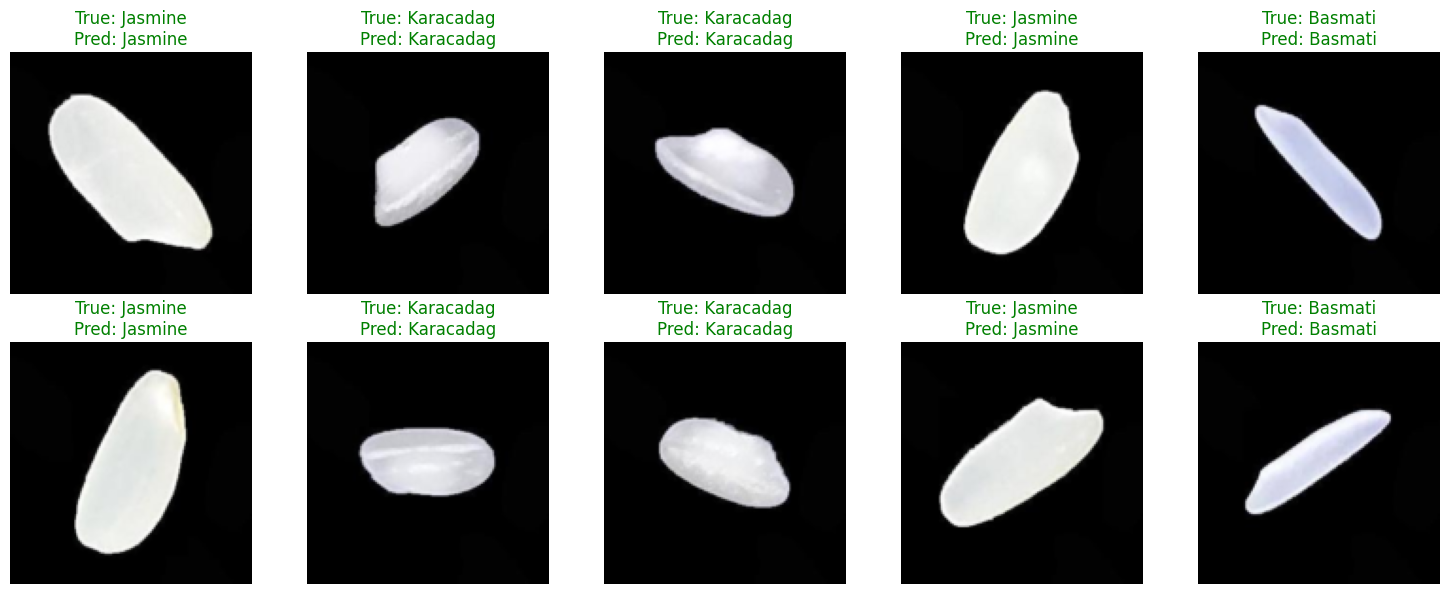

In [40]:
class_labels = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

# Get some test images, labels, and predictions
images_batch, labels_batch = next(iter(test_loader))  # Take one batch
images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images_batch)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images_batch = images_batch.cpu().numpy()
labels_batch = labels_batch.cpu().numpy()
preds = preds.cpu().numpy()  # Also move preds to CPU

# Plot actual vs predicted images
num_samples = min(10, len(images_batch))  # Ensure we don't exceed batch size
plt.figure(figsize=(15, 6))

for i in range(num_samples):
    img = images_batch[i]
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display

    true_label = class_labels[labels_batch[i]]
    pred_label = class_labels[preds[i]]

    plt.subplot(2, num_samples // 2, i + 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert (C, H, W) → (H, W, C)
    plt.title(f"True: {true_label}\nPred: {pred_label}", 
              color="green" if true_label == pred_label else "red", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()

## 7.7. Confusion Matrix

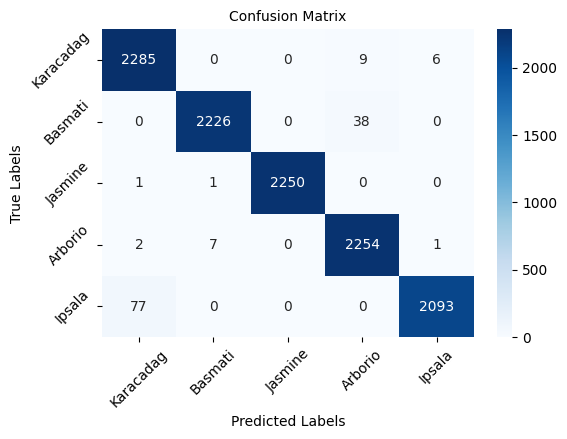

In [41]:
rice_classes = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio','Ipsala']
y_true = []
y_pred = []

for images, labels in test_loader:
        # Move to the device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Get model predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Append true labels and predicted labels to the respective lists
        y_true.extend(labels.cpu().numpy())  # True labels
        y_pred.extend(predicted.cpu().numpy())  # Predicted labels

# Now y_true and y_pred contain the true and predicted labels for the entire dataset

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Plot confusion matrix
plt.figure(figsize=(6,4))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax, annot_kws={"size": 10})

# Labels, title, and ticks
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.set_ylabel('True Labels', fontsize=10) 
ax.set_title('Confusion Matrix', fontsize=10)
ax.xaxis.set_ticklabels(rice_classes, fontsize=10, rotation=45)
ax.yaxis.set_ticklabels(rice_classes, fontsize=10, rotation=45)

plt.show()

## 7.8. Classification Report

In [42]:
report = classification_report(y_true, y_pred, target_names=rice_classes)

# Print the classification report
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

   Karacadag       0.97      0.99      0.98      2300
     Basmati       1.00      0.98      0.99      2264
     Jasmine       1.00      1.00      1.00      2252
     Arborio       0.98      1.00      0.99      2264
      Ipsala       1.00      0.96      0.98      2170

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250



# 8. Model 2: Two Conv layers and three fully connected layers

In [50]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.cnn_model1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5),  
            nn.BatchNorm2d(num_features=12),
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=2),  
            
            
            nn.Conv2d(in_channels=12, out_channels=20, kernel_size=5), 
            nn.BatchNorm2d(num_features=20),
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=2) 
            
        )

        self.fc_model1 = nn.Sequential(
            nn.Linear(in_features=20 * 29 * 29, out_features=320),  
            nn.ReLU(), 
            nn.Linear(in_features=320, out_features=64),
            nn.ReLU(),  
            nn.Linear(in_features=64, out_features=5)
        )

    def forward(self, x):
        x = self.cnn_model1(x)
        x = x.view(x.size(0), -1)  # Flatten before feeding into fully connected layers
        x = self.fc_model1(x)
        return x


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU (if available)
model1 = CNN1().to(device)

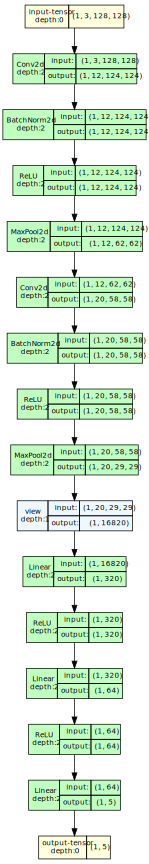

In [51]:
# Generate visualization
graph = draw_graph(model1, input_size=(1, 3, 128, 128), device='cpu')
graph.visual_graph

## 8.1. model Summary

In [52]:
summary(model1, (3, 128, 128), device=str(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 20, 29, 29]          --
|    └─Conv2d: 2-1                       [-1, 12, 124, 124]        912
|    └─BatchNorm2d: 2-2                  [-1, 12, 124, 124]        24
|    └─ReLU: 2-3                         [-1, 12, 124, 124]        --
|    └─MaxPool2d: 2-4                    [-1, 12, 62, 62]          --
|    └─Conv2d: 2-5                       [-1, 20, 58, 58]          6,020
|    └─BatchNorm2d: 2-6                  [-1, 20, 58, 58]          40
|    └─ReLU: 2-7                         [-1, 20, 58, 58]          --
|    └─MaxPool2d: 2-8                    [-1, 20, 29, 29]          --
├─Sequential: 1-2                        [-1, 5]                   --
|    └─Linear: 2-9                       [-1, 320]                 5,382,720
|    └─ReLU: 2-10                        [-1, 320]                 --
|    └─Linear: 2-11                      [-1, 64]                  20,544


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 20, 29, 29]          --
|    └─Conv2d: 2-1                       [-1, 12, 124, 124]        912
|    └─BatchNorm2d: 2-2                  [-1, 12, 124, 124]        24
|    └─ReLU: 2-3                         [-1, 12, 124, 124]        --
|    └─MaxPool2d: 2-4                    [-1, 12, 62, 62]          --
|    └─Conv2d: 2-5                       [-1, 20, 58, 58]          6,020
|    └─BatchNorm2d: 2-6                  [-1, 20, 58, 58]          40
|    └─ReLU: 2-7                         [-1, 20, 58, 58]          --
|    └─MaxPool2d: 2-8                    [-1, 20, 29, 29]          --
├─Sequential: 1-2                        [-1, 5]                   --
|    └─Linear: 2-9                       [-1, 320]                 5,382,720
|    └─ReLU: 2-10                        [-1, 320]                 --
|    └─Linear: 2-11                      [-1, 64]                  20,544


## 8.2. Training Model

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr = 0.001)

In [56]:
num_epochs = 5
train_losses, val_losses = [], []          # To track loss
train_accuracies, val_accuracies = [], []  # To track accuracy

for epoch in range(num_epochs):
    # Training phase
    model1.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available
        
        #Forward pass
        outputs = model1(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss tracking
        total_train_loss += loss.item()

        # Accuracy tracking
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model1.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model1(images)
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_val += (preds == labels).sum().item()
        total_val += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")
    print(f"            Train Acc = {train_accuracies[-1]:.4f}, Val Acc = {val_accuracies[-1]:.4f}")

Epoch [1/5]
Epoch 1: Train Loss = 0.1043, Val Loss = 0.1356
            Train Acc = 0.9646, Val Acc = 0.9562
Epoch [2/5]
Epoch 2: Train Loss = 0.0447, Val Loss = 0.1083
            Train Acc = 0.9852, Val Acc = 0.9672
Epoch [3/5]
Epoch 3: Train Loss = 0.0319, Val Loss = 0.0279
            Train Acc = 0.9888, Val Acc = 0.9905
Epoch [4/5]
Epoch 4: Train Loss = 0.0251, Val Loss = 0.0672
            Train Acc = 0.9918, Val Acc = 0.9771
Epoch [5/5]
Epoch 5: Train Loss = 0.0255, Val Loss = 0.1361
            Train Acc = 0.9918, Val Acc = 0.9494


## 8.3. Model History

In [60]:
history = {
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies,
}

result_model1 = pd.DataFrame(history)
result_model1

,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
0,0.104266,0.135589,0.964552,0.956178
1,0.044733,0.108322,0.985219,0.967200
2,0.031932,0.027896,0.988800,0.990489
3,0.025145,0.067234,0.991771,0.977067
4,0.025509,0.136105,0.991810,0.949422


## 8.4. Plot train (Acc/ Loss) vs Validation (Acc/ Loss)

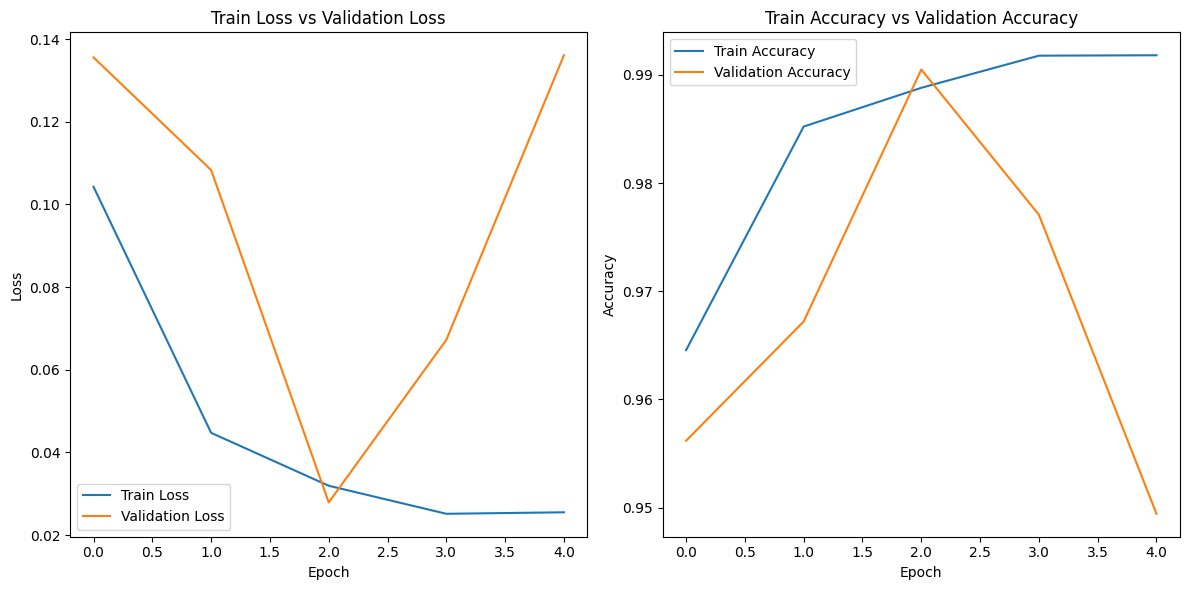

In [63]:
# Plot train loss vs validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(result_model1['Train Loss'], label='Train Loss')
plt.plot(result_model1['Validation Loss'], label='Validation Loss')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot train accuracy vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(result_model1['Train Accuracy'], label='Train Accuracy')
plt.plot(result_model1['Validation Accuracy'], label='Validation Accuracy')
plt.title('Train Accuracy vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 8.5. Test the model on the test set

In [65]:
# Set model1 to evaluation mode
model1.eval()

# Initialize counters
correct = 0
total = 0
test_loss = []
all_preds = []
all_labels = []
all_images = []


with torch.no_grad():    # Disable gradient computation for efficiency
    for images, labels in test_loader:
        # Move data to the same device as the model1
        images, labels = images.to(device), labels.to(device) 

        # output = prediction
        outputs  = model1(images)
        loss = criterion(outputs, labels)
        test_loss.append(loss.item())
        
        # Get predicted class indices
        # preds = torch.argmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)  # Get predicted class indices
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

         # Store predictions and true labels for confusion matrix
        all_preds.extend(preds.cpu().numpy())  # Convert to list
        all_labels.extend(labels.cpu().numpy())  # Convert to list

# Compute average test loss
avg_test_loss = np.mean(test_loss)
print(f'Test Average loss: {avg_test_loss:.4f}')

# Compute and print test accuracy
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f} %')   

Test Average loss: 0.1251
Test Accuracy: 95.46 %


## 8.6. Actual vs Predicted Image

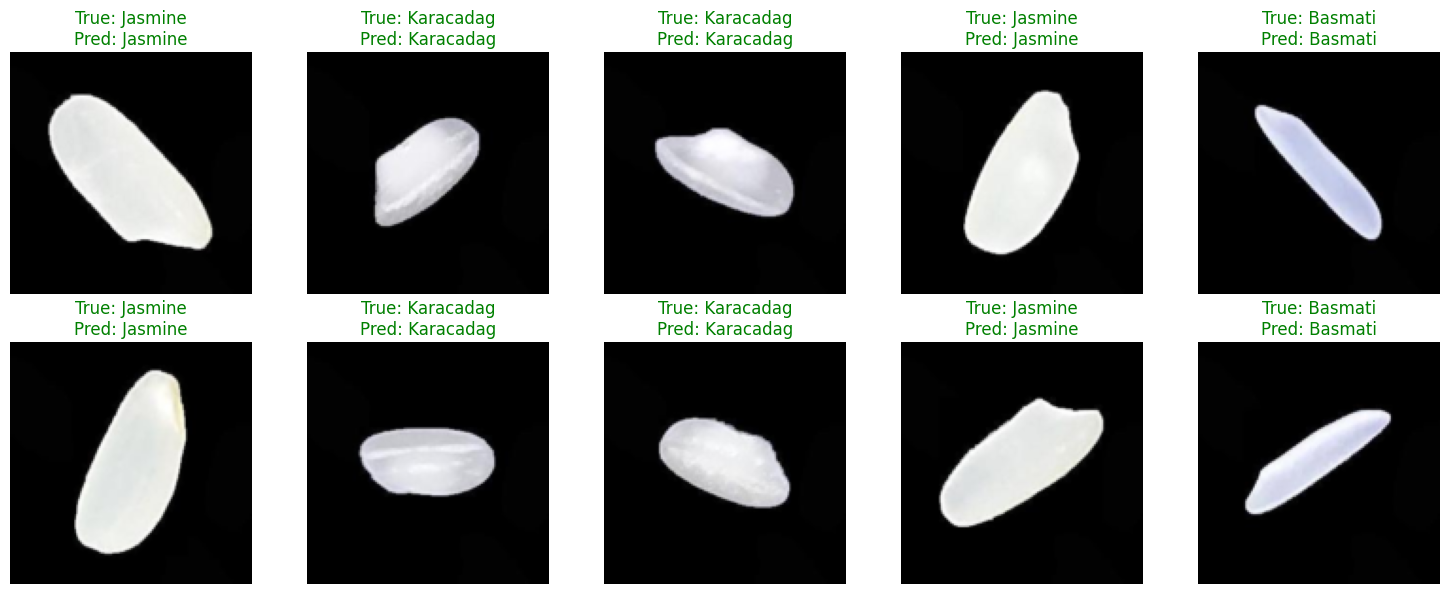

In [67]:
class_labels = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

# Get some test images, labels, and predictions
images_batch, labels_batch = next(iter(test_loader))  # Take one batch
images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

# Get model1 predictions
model1.eval()
with torch.no_grad():
    outputs = model1(images_batch)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images_batch = images_batch.cpu().numpy()
labels_batch = labels_batch.cpu().numpy()
preds = preds.cpu().numpy()  # Also move preds to CPU

# Plot actual vs predicted images
num_samples = min(10, len(images_batch))  # Ensure we don't exceed batch size
plt.figure(figsize=(15, 6))

for i in range(num_samples):
    img = images_batch[i]
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display

    true_label = class_labels[labels_batch[i]]
    pred_label = class_labels[preds[i]]

    plt.subplot(2, num_samples // 2, i + 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert (C, H, W) → (H, W, C)
    plt.title(f"True: {true_label}\nPred: {pred_label}", 
              color="green" if true_label == pred_label else "red", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()

## 8.7. Confusion Matrix

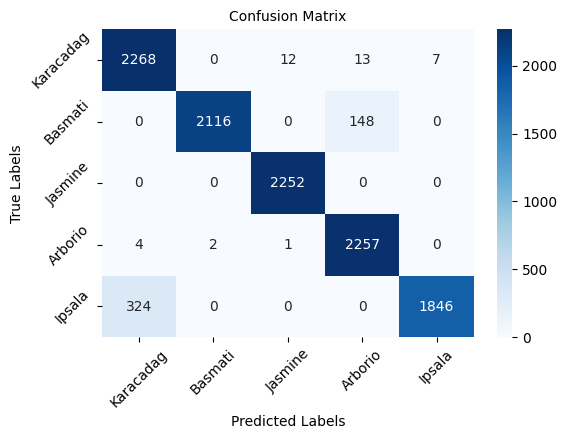

In [69]:
rice_classes = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio','Ipsala']
y_true = []
y_pred = []

for images, labels in test_loader:
        # Move to the device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Get model1 predictions
        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)

        # Append true labels and predicted labels to the respective lists
        y_true.extend(labels.cpu().numpy())  # True labels
        y_pred.extend(predicted.cpu().numpy())  # Predicted labels

# Now y_true and y_pred contain the true and predicted labels for the entire dataset

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Plot confusion matrix
plt.figure(figsize=(6,4))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax, annot_kws={"size": 10})

# Labels, title, and ticks
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.set_ylabel('True Labels', fontsize=10) 
ax.set_title('Confusion Matrix', fontsize=10)
ax.xaxis.set_ticklabels(rice_classes, fontsize=10, rotation=45)
ax.yaxis.set_ticklabels(rice_classes, fontsize=10, rotation=45)

plt.show()

## 8.8. Classification Report

In [81]:
report = classification_report(y_true, y_pred, target_names=rice_classes)

# Print the classification report
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

   Karacadag       0.87      0.99      0.93      2300
     Basmati       1.00      0.93      0.97      2264
     Jasmine       0.99      1.00      1.00      2252
     Arborio       0.93      1.00      0.96      2264
      Ipsala       1.00      0.85      0.92      2170

    accuracy                           0.95     11250
   macro avg       0.96      0.95      0.95     11250
weighted avg       0.96      0.95      0.95     11250

